## Remember to use MOU conda environment

In [1]:
# numpy and scipy
import numpy as np
import scipy.linalg as spl
import scipy.signal as spsg
import scipy.io as sio
import scipy.stats as stats

# MOU model
from test_MOU_largenet import MOUv2

# classification scikit-learn
import sklearn.linear_model as skllm
import sklearn.preprocessing as skppr
import sklearn.pipeline as skppl
import sklearn.neighbors as sklnn

# plotting
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sb
import pandas as pd

#statistical tests
import scipy.stats as stats

#importing ENIGMA
from enigmatoolbox.datasets import load_sc_as_one
from nilearn import plotting

In [2]:
data_dir = './' # data repo
res_dir = './' # results
graph_format = 'png' # graph formatting

conds = ['CTR', 'SCZ'] #conditions
 # number of conditions

# 68 is the number of brain regions
N = 68 # size of network for DK-68 

In [3]:
#NB: ./ = prendi il path
ts_ctr = sio.loadmat('./ts_ctr.mat')['ts_ctr'] 
ts_ctr=ts_ctr[0:68,:,20:68]
ts_scz = sio.loadmat('./ts_scz.mat')['ts_scz']
ts_scz=ts_scz[0:68]
ts_all = np.stack((ts_ctr, ts_scz), axis=-1)

ts_all.shape
#68 = brain regions
#48 = patients
#152 = time (?)
#2 = ctr, scz = conditions

(68, 152, 48, 2)

# Model optimization

In [4]:
# data and model parameters
subjects = np.arange(1, 48)
n_sub = len(subjects)
N = 68

mask_Sigma = np.eye(N,dtype=bool)
regul_Sigma = 0.0
conds = ['CTR', 'SCZ']
n_cond = len(conds) # number of conditions

min_val_EC = 0. # maximal value for EC
max_val_EC = 1. # maximal value for EC
min_val_Sigma = 0. # minimal value for Sigma

# arrays to store results
var_BOLD = np.zeros([n_sub,n_cond,N]) # empirical BOLD variance
J_mod = np.zeros([n_sub,n_cond,N,N]) # model Jacobian (EC)
Sigma_mod = np.zeros([n_sub,n_cond,N,N]) # model 
FC0_mod = np.zeros([n_sub,n_cond,N,N]) # model zero-lad FC
err_mod = np.zeros([n_sub,n_cond]) # model error
fit_mod = np.zeros([n_sub,n_cond]) # model goodness of fit (Pearson corr)

#0.008-0.09 Hz
#0.008 to 0.08 Hz

n_order = 3
TR = 2 # in seconds
Nyquist_freq = 0.5 / TR # Nyquist frequency
low_f = 0.001 / Nyquist_freq # lower cutoff for bandpass filter
high_f = 0.01 / Nyquist_freq # upper cutoff for bandpass filter
b,a = spsg.iirfilter(n_order,[low_f,high_f],btype='bandpass',ftype='butter')


# loop over subject and conditions
for i_sub in range(n_sub):
    for i_cond in range(n_cond):
        # get time serie
        ts3=ts_all[0:68, :,i_sub,i_cond]
        filt_ts = spsg.filtfilt(b,a,ts3,axis=1)
        ts=stats.zscore(ts3, axis=1)       #mask_EC=mask_ECS
        
        # store empirical BOLD variance
        var_BOLD[i_sub,i_cond,:] = ts.var(axis=1)
            #mask_EC=mask_ECS
        FC0 = np.tensordot(ts[:,:-1], ts[:,:-1], axes=(1,1)) / 149
        FC0N=abs(FC0)/np.max(abs(FC0))
        
        lim_FC0= np.percentile(FC0N, 50)

        # anatomy-derived mask for existing connections for EC
        mask_EC1 = np.zeros([N,N],dtype=bool) # EC weights to tune
        mask_EC1[FC0N>lim_FC0] = True
        for i in range(N):
            mask_EC1[i,i] = True # no self connection
            
        mask_EC = np.zeros([N,N],dtype=bool)
    
        #types of MASKS: 
        mask_EC=mask_EC1 
        
        # invert model
        mou_est = MOUv2()
        mou_est.fit(ts.T, mask_C=mask_EC, mask_Sigma=mask_Sigma, algo_version='true', min_iter=100, epsilon_C=0.005, epsilon_Sigma=0.005) #, verbose=True)

        # store results
        J_mod[i_sub,i_cond,:,:] = mou_est.J
        Sigma_mod[i_sub,i_cond,:,:] = mou_est.Sigma
        FC0_mod[i_sub,i_cond,:,:] = spl.solve_lyapunov(J_mod[i_sub,i_cond,:,:].T, -Sigma_mod[i_sub,i_cond,:,:])
        err_mod[i_sub,i_cond] = mou_est.d_fit['distance']
        fit_mod[i_sub,i_cond] = mou_est.d_fit['correlation']

        print('sub', i_sub, '; cond', i_cond, ':', mou_est.d_fit)

#%% save results
np.save(res_dir+'J_mod.npy',J_mod)
np.save(res_dir+'Sigma_mod.npy',Sigma_mod)
np.save(res_dir+'FC0_mod.npy',FC0_mod)

np.save(res_dir+'err_mod.npy',err_mod)
np.save(res_dir+'fit_mod.npy',fit_mod)

np.save(res_dir+'var_BOLD.npy',var_BOLD)


sub 0 ; cond 0 : {'n_tau': 2, 'iterations': 102, 'distance': np.float64(0.8340560536018315), 'correlation': np.float64(0.6083011355068169), 'distance history': array([0.91124857, 0.90953284, 0.90783844, ..., 0.        , 0.        ,
       0.        ]), 'correlation history': array([0.38559493, 0.39081964, 0.39597241, ..., 0.        , 0.        ,
       0.        ]), 'distFC0': np.float64(1.0078171046273232), 'distFC1': np.float64(1.3231093263395317)}
sub 0 ; cond 1 : {'n_tau': 2, 'iterations': 102, 'distance': np.float64(0.8682958462890833), 'correlation': np.float64(0.6032792169086564), 'distance history': array([0.91644941, 0.91248404, 0.90905139, ..., 0.        , 0.        ,
       0.        ]), 'correlation history': array([0.37261965, 0.40313686, 0.43024487, ..., 0.        , 0.        ,
       0.        ]), 'distFC0': np.float64(40.15682824227184), 'distFC1': np.float64(123015.41491762917)}
sub 1 ; cond 0 : {'n_tau': 2, 'iterations': 102, 'distance': np.float64(0.8558232185237954)

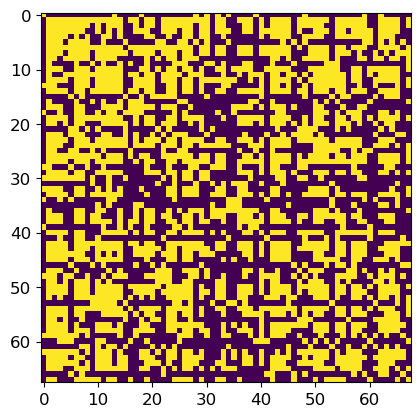

In [11]:
plt.imshow(mask_EC1)

## Check goodness of fit : 

/tmp/ipykernel_5410/4027539692.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.violinplot(data=err_mod_df, x='cond', y='sum EC', palette=cols)
/tmp/ipykernel_5410/4027539692.py:16: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sb.violinplot(data=err_mod_df, x='cond', y='sum EC', palette=cols)
/tmp/ipykernel_5410/4027539692.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.violinplot(data=fit_mod_df, x='cond', y='sum EC', palette=cols)
/tmp/ipykernel_5410/4027539692.py:39: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sb.violinplot(data=fit_mod_df, x='cond', y='sum EC', palette=cols)


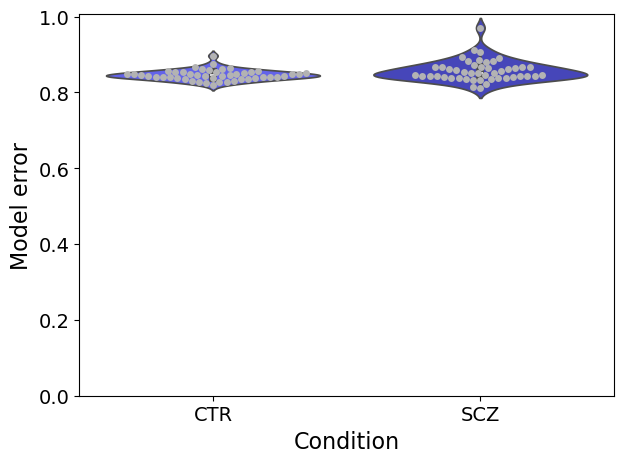

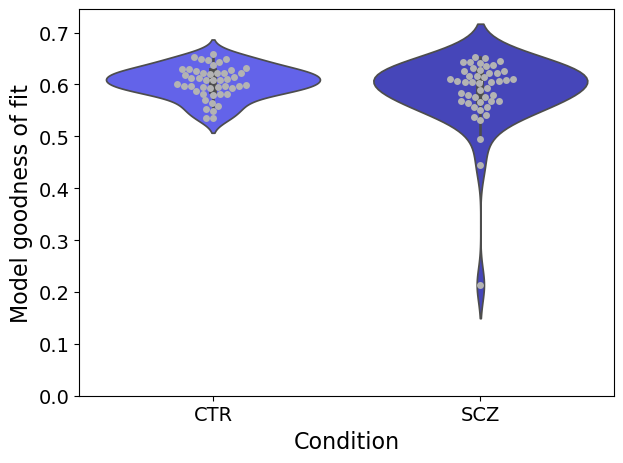

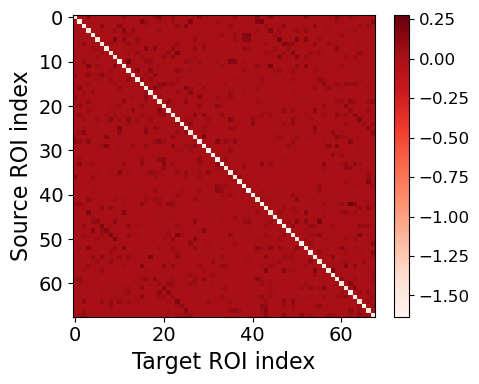

In [12]:
mask_diag = np.eye(N, dtype=bool) # mask for diagonal elements
n_cond=2

cols = [[0.3,0.3,1],[0.2,0.2,0.8],[0.1,0.1,0.6],[0,0,0.4]] # colors

# model error #err_mod

err_mod_tmp = dict()
err_mod_tmp['sum EC'] = err_mod.flatten()
err_mod_tmp['sub'] = np.repeat(np.arange(n_sub), n_cond).flatten()
err_mod_tmp['cond'] = np.repeat(np.array(conds, dtype=str).reshape([-1,n_cond]), n_sub, axis=0).flatten()

err_mod_df = pd.DataFrame(err_mod_tmp)

plt.figure()
sb.violinplot(data=err_mod_df, x='cond', y='sum EC', palette=cols)
sb.swarmplot(data=err_mod_df, x='cond', y='sum EC', color=[0.7,0.7,0.7])
plt.axis(ymin=0)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Condition',fontsize=16)
plt.ylabel('Model error',fontsize=16)

plt.tight_layout()
plt.savefig(res_dir+'model_fit_error.eps', format='eps')


# Pearson corr #fit_mod

fit_mod_tmp = dict()
fit_mod_tmp['sum EC'] = fit_mod.flatten()
fit_mod_tmp['sub'] = np.repeat(np.arange(n_sub), n_cond).flatten()
fit_mod_tmp['cond'] = np.repeat(np.array(conds, dtype=str).reshape([-1,n_cond]), n_sub, axis=0).flatten()

fit_mod_df = pd.DataFrame(fit_mod_tmp)

plt.figure()
sb.violinplot(data=fit_mod_df, x='cond', y='sum EC', palette=cols)
sb.swarmplot(data=fit_mod_df, x='cond', y='sum EC', color=[0.7,0.7,0.7])
plt.axis(ymin=0)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Condition',fontsize=16)
plt.ylabel('Model goodness of fit',fontsize=16)

plt.tight_layout()
plt.savefig(res_dir+'model_goodness_fit.eps', format='eps')


# Example EC

plt.figure(figsize=(5,4))
#plt.imshow(np.maximum(J_mod[18,1,:,:],0), cmap='Reds')
plt.imshow(J_mod[18,1,:,:], cmap='Reds')
plt.colorbar()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Target ROI index', fontsize=16)
plt.ylabel('Source ROI index', fontsize=16)
plt.tight_layout()
plt.savefig(res_dir+'example_EC.eps', format='eps')

## ENTROPY CALCULATION

In [7]:

# transpose to Saclay's framework
EPR = np.zeros([n_sub,n_cond])
Q_indiv = np.zeros([n_sub,n_cond,N,N])

for i_sub in range(n_sub):
    for i_cond in range(n_cond):

        try:
            B = np.copy(-J_mod[i_sub,i_cond,:,:].T)
            D = np.copy(0.5 * Sigma_mod[i_sub,i_cond,:,:])
            S = np.copy(FC0_mod[i_sub,i_cond,:,:])
            
            Q = np.dot(B, S) - D
            Q_indiv[i_sub,i_cond,:,:] = Q
            
            # sanity check
            if True:
                print('should be close to zero:', np.abs(np.dot(B,S) + np.dot(S,B.T) -2*D).max())
            
            # formula from Godreche Luck
            Dinv = np.linalg.pinv(D)
            Sinv = np.linalg.pinv(S)
            
            entropy_prod_rate = -np.trace(np.dot(np.dot(np.dot(Sinv, Q), Dinv), Q))
            EPR[i_sub,i_cond] = entropy_prod_rate

        except:
            print('problem with subject/cond:', i_sub, i_cond)

should be close to zero: 1.1102230246251565e-14
should be close to zero: 2.220446049250313e-14
should be close to zero: 9.992007221626409e-15
should be close to zero: 2.220446049250313e-14
should be close to zero: 2.1316282072803006e-14
should be close to zero: 1.2434497875801753e-14
should be close to zero: 6.217248937900877e-15
should be close to zero: 9.769962616701378e-15
should be close to zero: 1.865174681370263e-14
should be close to zero: 8.43769498715119e-15
should be close to zero: 7.327471962526033e-15
should be close to zero: 7.105427357601002e-15
should be close to zero: 9.325873406851315e-15
should be close to zero: 1.199040866595169e-14
should be close to zero: 7.549516567451064e-15
should be close to zero: 6.217248937900877e-15
should be close to zero: 4.6629367034256575e-15
should be close to zero: 3.907985046680551e-14
should be close to zero: 1.7319479184152442e-14
should be close to zero: 1.1546319456101628e-14
should be close to zero: 1.0658141036401503e-14
should 

/tmp/ipykernel_5410/2923277758.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sb.violinplot(data=EPR_df, x='sleep stage', y='EPR', palette=cols)
/tmp/ipykernel_5410/2923277758.py:20: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  ax = sb.violinplot(data=EPR_df, x='sleep stage', y='EPR', palette=cols)


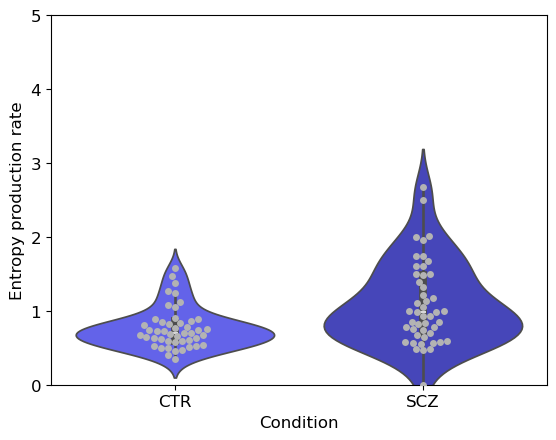

In [8]:

#%% plots

matplotlib.rc('font', size=12) 
matplotlib.rc('xtick', labelsize=12)
matplotlib.rc('ytick', labelsize=12)

cols = [[0.3,0.3,1],[0.2,0.2,0.8],[0.1,0.1,0.6],[0,0,0.4]]
cols2 = [[0.7,0.7,1],[0.6,0.6,1],[0.5,0.5,1],[0.4,0.4,1]]

EPR_tmp = dict()
EPR_tmp['sleep stage'] = np.repeat(np.array(conds, dtype=str).reshape([-1,n_cond]), n_sub, axis=0).flatten()
EPR_tmp['EPR'] = EPR.flatten()

EPR_df = pd.DataFrame(EPR_tmp)


# real data

plt.figure()
ax = sb.violinplot(data=EPR_df, x='sleep stage', y='EPR', palette=cols)
sb.swarmplot(data=EPR_df, x='sleep stage', y='EPR', color=[0.7,0.7,0.7])
plt.axis(ymin=0, ymax=5)

plt.xlabel('Condition', fontsize=12)
plt.ylabel('Entropy production rate', fontsize=12)

plt.savefig(res_dir+'entropy_prod_rate.eps', format='eps')

In [9]:
EPR_df

,sleep stage,EPR
0,CTR,0.749603
1,SCZ,1.491123
2,CTR,0.575835
3,SCZ,2.668329
4,CTR,1.119596
...,...,...
89,SCZ,0.480855
90,CTR,0.495420
91,SCZ,0.671289
92,CTR,0.868226


Verify that the two groups are 
## Statistically Different


3. Check if the two groups are statistically different: WELCH TEST

In [10]:
CTR = EPR[:,0]
SCZ = EPR[:,1]
stat_t, p_t = stats.ttest_ind(CTR, SCZ, equal_var=False)

print(f"Welch's t-test statistic: {stat_t:.3f}, p-value: {p_t:.3f}")

if p_t < 0.05:
    print("The difference between groups is statistically significant.")
else:
    print("No significant difference between groups.")

Welch's t-test statistic: -3.590, p-value: 0.001
The difference between groups is statistically significant.
